# Standard pipeline: analyzing 5K PBMC dataset from 10X genomics


## Introduction <a name="introduction"></a>

In this tutorial we will analyze single-cell ATAC-seq data from Peripheral blood mononuclear cells (PBMCs).

## Import library and environment setup <a name="setup"></a>

In [1]:
import snapatac2 as snap

snap.__version__

'2.1.3.1'

Download the fragment file.

In [2]:
# Input files
fragment_file = snap.datasets.pbmc5k()
fragment_file

PosixPath('/home/kaizhang/.cache/snapatac2/atac_pbmc_5k.tsv.gz')

## Preprocessing <a name="preprocessing"></a>

We start off on data preprocessing by importing the fragment files and computing QC metric, which is achieved by calling the funciton `import_data`.

This function generates genome-wide TN5 insertion counts and stored the result in an AnnData object (Click [here](https://kzhang.org/epigenomics-analysis/anndata.html) to learn more about SnapATAC2's `anndata` implementation). During this process, various quality controls, such as TSS enrichment, the number of unique fragments per cell, will also be computed and stored in the anndata.

By default the AnnData object is created and stored in the computer memory. If the `file` parameter is provided, the AnnData object will be backed by a hdf5 file. In the "backed" mode, `import_data` will process the data by chunks and stream the result to the disk. As a result, only a small fixed amount of memory will be used. So it is advised to specify the `file` parameter when your input is large and memory is scarse. Note that analyzing data in "backed" mode is slightly slower than that in "memory" mode.

In this tutorial we will use the backed mode. To learn more about the differences between these two modes, click [here](https://kzhang.org/epigenomics-analysis/anndata.html).

In [3]:
%%time
data = snap.pp.import_data(
    fragment_file,
    genome=snap.genome.hg38,
    file="pbmc.h5ad",
    sorted_by_barcode=False,
)
data

CPU times: user 11min 3s, sys: 33.7 s, total: 11min 37s
Wall time: 3min 13s


AnnData object with n_obs x n_vars = 14227 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

To identify usable/high-quality cells, we can plot TSS enrichment against number of unique fragments for each cell.

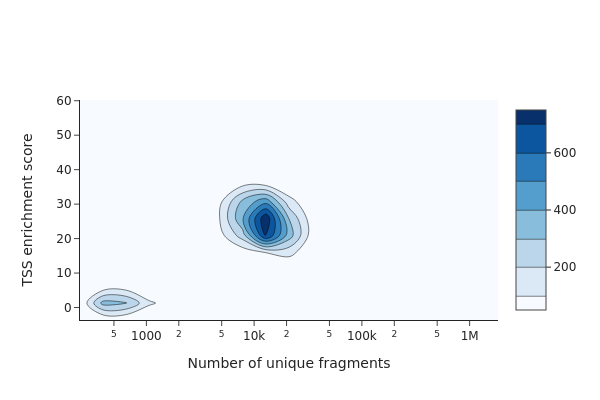

In [4]:
snap.pl.tsse(data, interactive=False)

The cells on the upper right corresponds to valid/high-quality cells, while the cells on the lower left corresponds to low-quality cells or empty dropblets. According to this plot, we decided to choose minimum TSS enrichment of 10 and minimum number of fragments of 5000 to filter the cells.

In [5]:
%%time
snap.pp.filter_cells(data, min_counts=5000, min_tsse=10, max_counts=50000)
data

CPU times: user 18.8 s, sys: 2.71 s, total: 21.5 s
Wall time: 21.6 s


AnnData object with n_obs x n_vars = 4544 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

We next create a cell by bin matrix containing insertion counts across genome-wide 500-bp bins.

In [6]:
%%time
snap.pp.add_tile_matrix(data)

CPU times: user 57.3 s, sys: 8.7 s, total: 1min 6s
Wall time: 41.8 s


We next perform feature selection to remove bins with low variability. The result is stored in `data.var["selected"]` and will be automatically picked up by relavent functions such as `snap.pp.scrublet` and `snap.tl.spectral`.

The default feature selection algorithm selects variable features. You can pass filter list to the function such as blacklist or whitelist. For example, `pp.select_features(data, blacklist="blacklist.bed")`.

In [7]:
snap.pp.select_features(data)

### Doublet removal

Here we apply a customized scrublet algorithm to identify potential doublets. Calling `snap.pp.scrublet` will assign a doublet score to each cell. We can then use `snap.pp.call_doublets` to get the doublet score threshold to identify potential doublets. The result can be plotted by `snap.pl.scrublet`.

In [8]:
%%time
snap.pp.scrublet(data)

2022-11-10 20:48:36 - INFO - Simulating doublets...
2022-11-10 20:48:37 - INFO - Spectral embedding ...
2022-11-10 20:49:04 - INFO - Calculating doublet scores...


CPU times: user 2min 17s, sys: 41.1 s, total: 2min 58s
Wall time: 1min 8s


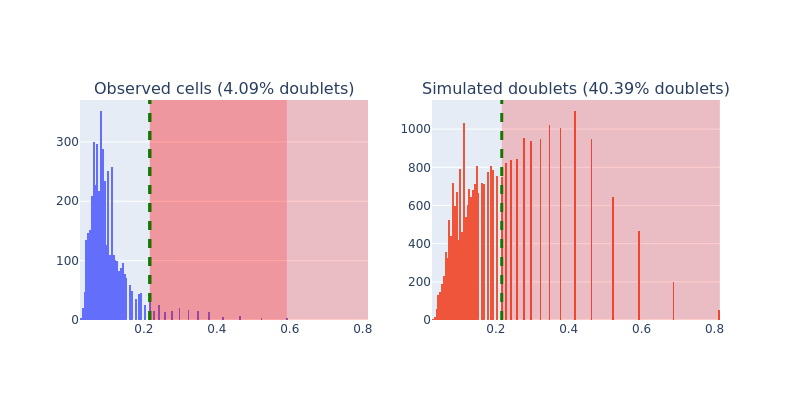

In [9]:
snap.pp.call_doublets(data)
snap.pl.scrublet(data, interactive=False)

This line does the actual filtering. Note the `.subset()` method is available only in backed mode. To subset an in-memory AnnData object, use: `data = data[~data.obs["is_doublet"], :]` instead.

In [10]:
data.subset(~data.obs["is_doublet"])
data

AnnData object with n_obs x n_vars = 4358 x 6176550 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet'
    var: 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score', 'scrublet_threshold'
    obsm: 'insertion'

## Dimenstion reduction <a name="dimension_reduction"></a>

To compute the lower dimensional representation of single-cell chromatin profiles, we first compute the pairwise read-depth normalized jaccard similarity. We then use the spectral embedding to perform the dimension reduction. All these steps were packed into a single function `snap.tl.spectral`. The result is stored in `data.obsm['X_spectral']`. Note we also provide alternative similarity metric such as the cosine similarity. Full details about the algorithm we used in dimension reduction can be found [here](../algorithms/dimension_reduction.rst).

In [11]:
%%time
snap.tl.spectral(data)

2022-11-10 20:50:28 - INFO - Compute similarity matrix
2022-11-10 20:50:29 - INFO - Normalization
2022-11-10 20:50:30 - INFO - Perform decomposition


CPU times: user 51.9 s, sys: 24 s, total: 1min 15s
Wall time: 34.8 s


We then plot the top eigenvalues corresponding to the first `n` eigenvectors/components. Using the elbow method, we pick the first 10 components in subsequent analysis. Note that selecting approporiate number of components is critical for getting best clustering accuracy.

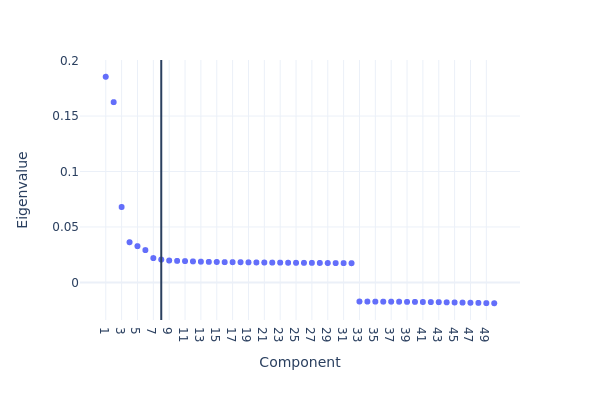

In [12]:
snap.pl.spectral_eigenvalues(data, interactive=False)

We then use UMAP to embed the cells to 2-dimension space for visualization purpose. This step will have to be run after `snap.tl.spectral` as it uses the lower dimesnional representation created by the spectral embedding.

In [13]:
%%time
snap.tl.umap(data, use_dims=10)

/home/kaizhang/data/software/miniconda3/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning:

Tensorflow not installed; ParametricUMAP will be unavailable



CPU times: user 33.5 s, sys: 5.57 s, total: 39.1 s
Wall time: 32.4 s


## Clustering analysis <a name="clustering"></a>

We next perform graph-based clustering to identify cell clusters. We first build a k-nearest neighbour graph using `snap.pp.knn`, and then use the Leiden community detection algorithm to identify densely-connected subgraphs/clusters in the graph. The graph-based clustering algorithm usually outperform other methods. Here we also run the k-means algorithm as a comparison.

In [14]:
%%time
snap.pp.knn(data, use_dims=10)
snap.tl.leiden(data)

CPU times: user 3 s, sys: 159 ms, total: 3.16 s
Wall time: 1.31 s


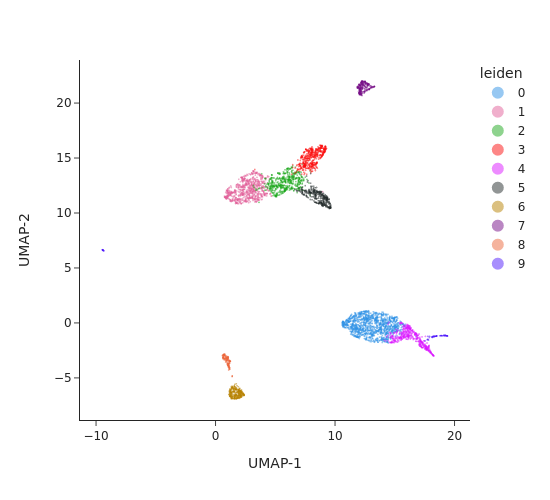

In [15]:
snap.pl.umap(data, color="leiden", interactive=False)

## Cell cluster annotation <a name="annotation"></a>

### Create the cell by gene activity matrix

Now that we have the cell clusters, we will try to annotate the clusters and assign them to known cell types. To do this, we need to compute the gene activities first for each cell using the `pp.make_gene_matrix` function.

Just like `pp.import_data`, `pp.make_gene_matrix` allows you to provide an optional file name used to store the AnnData object. To demo the in-memory mode of AnnData, we will not provide the `file` parameter this time.

In [16]:
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38)
gene_matrix

CPU times: user 2min 41s, sys: 6.52 s, total: 2min 48s
Wall time: 31.2 s


AnnData object with n_obs × n_vars = 4358 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'

### Imputation

The cell by gene activity matrix is usually very sparse. To ease the visulization and marker gene identification, we use the MAGIC algorithm to perform imputation and data smoothing. The subsequent steps are similar to those in single-cell RNA-seq analysis, we therefore leverage the [scanpy](https://scanpy.readthedocs.io/en/stable/) package to do this.

Since we have stored the gene matrix in in-memory mode, we can directly pass it to scanpy. If the AnnData object is in backed mode, you need to convert it to an in-memory representation using the `.to_memory()` method.

We first perform gene filtering, data normalization, data transformation, and then call the `sc.external.pp.magic` function to complete the imputation.

In [17]:
import scanpy as sc

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

/home/kaizhang/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [18]:
%%time
sc.external.pp.magic(gene_matrix, solver="approximate")

/home/kaizhang/.local/lib/python3.8/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



CPU times: user 52.7 s, sys: 27.3 s, total: 1min 19s
Wall time: 38.5 s


In [19]:
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

We can now visualize the gene activity of a few marker genes.

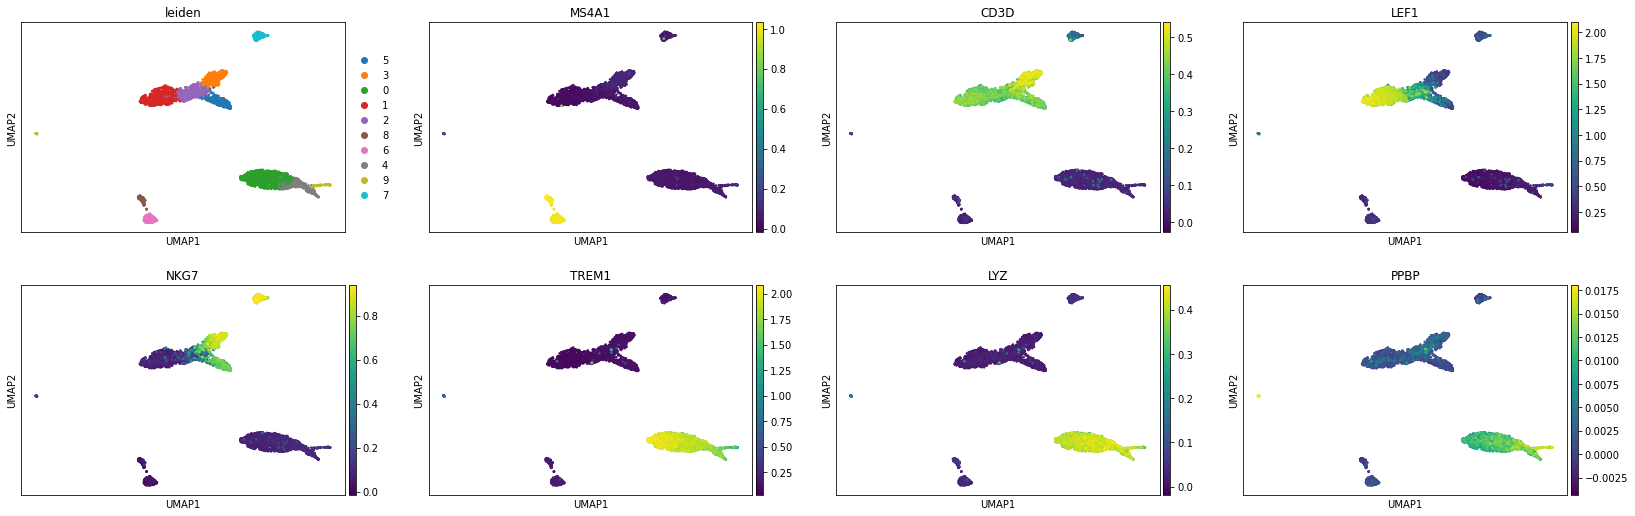

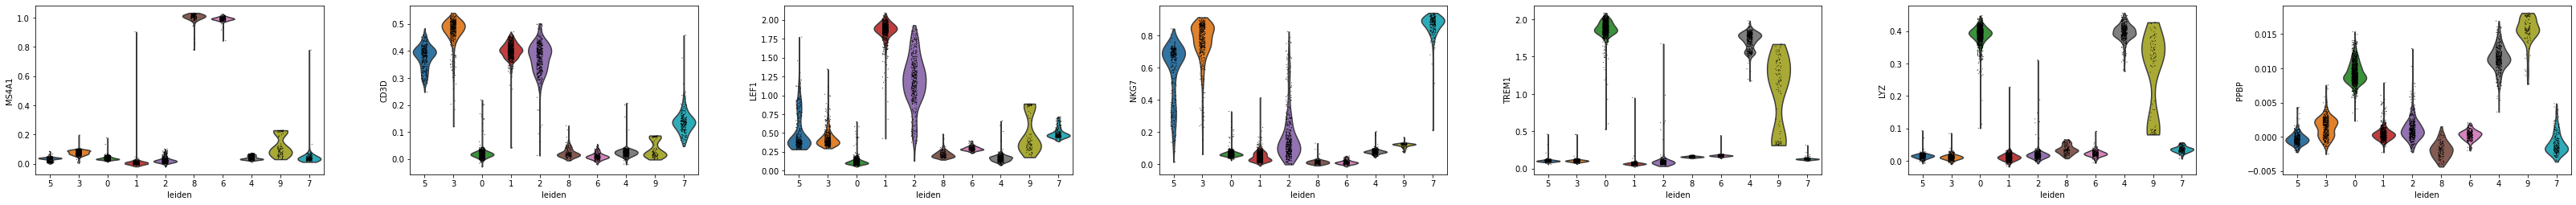

In [20]:
marker_genes = ['MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ', 'PPBP']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes)
sc.pl.violin(gene_matrix, marker_genes, use_raw=False, groupby='leiden')

## Peak calling at the cluster-level

An important goal of single-cell ATAC-seq analysis is to identify genomic regions that are enriched with TN5 insertions, or "open chromatin" regions. Using `snap.tl.call_peaks`, we can easily identify open chromatin regions in different cell populations stratified by provided group information.

In [21]:
%%time
snap.tl.call_peaks(data, groupby="leiden")

2022-11-10 20:54:11 - INFO - Exporting data...
2022-11-10 20:59:14 - INFO - Calling peaks for 10 groups ...
2022-11-10 21:01:30 - INFO - Merging peaks...


CPU times: user 5min 5s, sys: 11 s, total: 5min 16s
Wall time: 7min 21s


`snap.tl.call_peaks` first calls peaks for individual groups and then merges overlapping peaks to create a list of fix-width non-overlapping peaks. The intermediate results are discarded by default but can be saved using the `out_dir` parameter.

Results of peak calling are stored in `data.uns['peaks']` as a dataframe. Rows are merged peaks, and columns are cell clusters. Boolean values in the dataframe indicate whether a peak is present in a given cell cluster.

In [22]:
data.uns['peaks'].head()

shape: (5, 11)
┌────────────────────┬───────┬───────┬───────┬─────┬───────┬───────┬───────┬───────┐
│ Peaks              ┆ 8     ┆ 7     ┆ 4     ┆ ... ┆ 5     ┆ 3     ┆ 0     ┆ 6     │
│ ---                ┆ ---   ┆ ---   ┆ ---   ┆     ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str                ┆ bool  ┆ bool  ┆ bool  ┆     ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞════════════════════╪═══════╪═══════╪═══════╪═════╪═══════╪═══════╪═══════╪═══════╡
│ chr1:180649-181150 ┆ false ┆ true  ┆ false ┆ ... ┆ false ┆ true  ┆ true  ┆ false │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ chr1:181197-181698 ┆ false ┆ false ┆ false ┆ ... ┆ false ┆ false ┆ false ┆ false │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ chr1:191594-192095 ┆ false ┆ true  ┆ false ┆ ... ┆ true  ┆ true  ┆ true  ┆ false │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ chr1:267750-268251 ┆ false ┆ false ┆ true  ┆ ... ┆ false ┆ true  ┆ true  ┆ false │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ chr1:280496-280997 ┆ false ┆ false ┆ false ┆ ... ┆ false ┆ false ┆ true  ┆ false │
└────────────────────┴───────┴───────┴───────┴─────┴───────┴───────┴───────┴───────┘

Now, with the peak list, we can create a cell by peak matrix by `snap.pp.make_peak_matrix`.

In [23]:
%%time
peak_mat = snap.pp.make_peak_matrix(data, file="peak_matrix.h5ad")
peak_mat

CPU times: user 1min 31s, sys: 5.75 s, total: 1min 37s
Wall time: 31 s


AnnData object with n_obs x n_vars = 4358 x 241999 backed at 'peak_matrix.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'

### Close AnnData objects

When the AnnData objects are opened in backed mode, they will be synchronized with the underlying HDF5 files, which means there is no need to manually save the results during the analysis and the files are always up to date. As a side effect, **it is important to close every backed AnnData object before shutdown the Python process to avoid HDF5 file corruptions!**

In [24]:
peak_mat.close()
data.close()
data

Closed AnnData object

Also, remember to save any in-memory AnnData objects.

In [25]:
gene_matrix.write("gene_matrix.h5ad")

Now it is safe to close and shutdown the notebook! Next time you can load the results using `data = snap.read("pbmc.h5ad")`.

## What's next?

- [Cell type annotation](https://kzhang.org/SnapATAC2/tutorials/annotation.html)
- [Differential peak and motif analysis](https://kzhang.org/SnapATAC2/tutorials/diff.html)